# [Fast RG - quickly sampling a sparse matrix with low rank expectation](https://arxiv.org/pdf/1703.02998.pdf)

R Code: https://github.com/RoheLab/fastRG/
Python original implementation: https://github.com/yunjhongwu/matrix-routines/blob/master/fastRG.py

Key algorithm:


```
Require: X ∈ Rn×Kx, S ∈ RKx×Ky, and Y ∈ Rd×Ky with all matrices containing non-negative entries.
Compute diagonal matrix CX ∈ RKx×Kx with CX = diag(∑i Xi1 , ... , ∑i XiKx).
Compute diagonal matrix CY ∈ RKy×Ky with CY = diag(∑i Yi1 , ... , ∑i YiKy).
Define X˜ = XC−1X, S˜ = CX SCY , and Y˜ = YC−1Y.
Sample the number of edges m ∼ Poisson(∑u,v S˜uv).
for ` = 1 : m do
    Sample U ∈ {1, ..., Kx},V ∈ {1, ..., Ky} with P(U = u,V = v) ∝ S˜uv.
    Sample I ∈ {1, ..., n} with P(I = i) = X˜iU .
    Sample J ∈ {1, ..., d} with P(J = j) = Y˜jV .
    Add edge (I, J) to the graph, allowing for multiple edges (I, J).
end for
```


In [1]:
import numpy as np
import scipy.sparse as scs

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
N, D = 10, 7
K1, K2 = 5, 4

In [3]:
def create_sparse_matrix(N,K):
    cols = np.random.randint(K, size=(N,)) # membership
    rows = np.arange(N, dtype=int)
    data = np.ones_like(rows)
    
    X = scs.csc_matrix((data, (rows, cols)), shape=(N,K))
    return X

def plot_matrix(X, name="X", ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    if not isinstance(X, np.ndarray):
        X = X.toarray()
    sns.heatmap(
        X, cmap="Reds", 
        vmin=0, vmax=1,
        linewidths=.5,
        square=True, cbar=False, 
        ax=ax
    )
    ax.set_title(name)

In [4]:
X = create_sparse_matrix(N,K1)
Y = create_sparse_matrix(D,K2)
S = create_sparse_matrix(K1,K2)
X, Y, S

(<10x5 sparse matrix of type '<class 'numpy.longlong'>'
 	with 10 stored elements in Compressed Sparse Column format>,
 <7x4 sparse matrix of type '<class 'numpy.longlong'>'
 	with 7 stored elements in Compressed Sparse Column format>,
 <5x4 sparse matrix of type '<class 'numpy.longlong'>'
 	with 5 stored elements in Compressed Sparse Column format>)

In [5]:
A = X.dot(S).dot(Y.T)
A

<10x7 sparse matrix of type '<class 'numpy.longlong'>'
	with 7 stored elements in Compressed Sparse Column format>

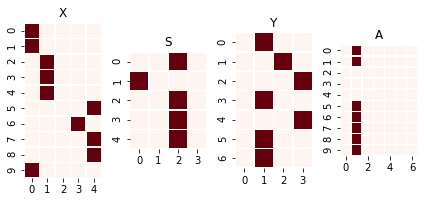

In [6]:
fig, ax = plt.subplots(1,4)
plot_matrix(X, name="X", ax=ax[0])
plot_matrix(S, name="S", ax=ax[1])
plot_matrix(Y, name="Y", ax=ax[2])
plot_matrix(A, name="A", ax=ax[3])
fig.tight_layout()

In [7]:
class FastRG(object):
    def __init__(self, X, Y, S):        
        self.X_prime, self.Y_prime, self.S_prime = FastRG.compute_primes(X, Y, S)
        
    @classmethod
    def compute_C(cls, X):
        CX = np.asarray(X.sum(axis=0)).sum(axis=0)#.ravel()
        return CX
    
    @classmethod
    def compute_primes(cls, X, Y, S):
        CX = FastRG.compute_C(X)
        CY = FastRG.compute_C(Y)
        
        X_prime = X / CX
        Y_prime = Y / CY
        S_prime = CX[:, np.newaxis] * S.toarray() * CY # CX.dot(S.toarray()).dot(CY)
        
        return X_prime, Y_prime, S_prime
    
    @classmethod
    def sample_block_edges(cls, S_prime, m):        
        UV_counts = np.random.multinomial(m, S_prime.ravel()/S_prime.sum()).reshape(S_prime.shape)
        UV_counts_indices = np.indices(UV_counts.shape) # row, col
        U, V = UV_counts_indices[:, UV_counts > 0]
        UV_counts_nz = UV_counts[U, V]
        
        return U, V, UV_counts_nz
    
    @classmethod
    def sample_edges(cls, X_prime, Y_prime, U, V, UV_counts_nz, m):
        sampled_edges = set()
        sampled_edges_ids = dict()
        for i,(u,v,c) in enumerate(zip(U, V, UV_counts_nz)):
            print(f"Sampling using u={u}, v={v}, c={c}")
            uv_edges = set()
            remaining_edges = c - len(uv_edges)
            while remaining_edges > 0:
                i_samples = np.random.choice(np.arange(N), p=np.asarray(X_prime[:, u]).ravel(), size=c)
                j_samples = np.random.choice(np.arange(D), p=np.asarray(Y_prime[:, v]).ravel(), size=c)
#                 print(i_samples, j_samples)
                new_edges = set(zip(i_samples, j_samples)) - uv_edges
                if len(new_edges) >= remaining_edges:
                    new_edges = list(new_edges)[:remaining_edges]
                uv_edges.update(new_edges)
                uv_edges = uv_edges - sampled_edges
                remaining_edges = c - len(uv_edges)
                break
                # print(f"\tremaining_edges={remaining_edges}: {new_edges}")
            sampled_edges_ids.update({e: i for e in uv_edges - sampled_edges})
            sampled_edges.update(uv_edges)
        
        print(f"Sampled {len(sampled_edges)} edges, needed: {m}")

        sampled_rows, sampled_cols = map(np.array, zip(*list(sampled_edges)))
        data = [sampled_edges_ids[(u,v)] for u,v in zip(sampled_rows, sampled_cols)]
#         data = np.ones_like(sampled_rows)
        
        
        return data, sampled_rows, sampled_cols
        
        
        
    def sample(self):
        X_prime, Y_prime, S_prime = self.X_prime, self.Y_prime, self.S_prime
        
        N, K1 = X_prime.shape
        D, K2 = Y_prime.shape
        
        m = np.random.poisson(S_prime.sum())        
        
        U, V, UV_counts_nz = FastRG.sample_block_edges(S_prime, m)
        data, sampled_rows, sampled_cols = FastRG.sample_edges(X_prime, Y_prime, U, V, UV_counts_nz, m)
        
#         UV_counts = np.random.multinomial(m, S_prime.ravel()/S_prime.sum()).reshape(K1,K2)
#         UV_counts_indices = np.indices(UV_counts.shape) # row, col
#         U, V = UV_counts_indices[:, UV_counts > 0]
#         UV_counts_nz = UV_counts[U, V]

        sample_G = scs.csc_matrix((data, (sampled_rows, sampled_cols)), shape=(N,D))
        
        
        return sample_G

In [8]:
sampler = FastRG(X, Y, S)

/Users/smishra/miniconda3/lib/python3.7/site-packages/scipy/sparse/base.py:599: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)
/Users/smishra/miniconda3/lib/python3.7/site-packages/scipy/sparse/base.py:599: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


In [9]:
sampled_A = sampler.sample()

Sampling using u=0, v=2, c=3
Sampling using u=4, v=2, c=1
Sampled 2 edges, needed: 4


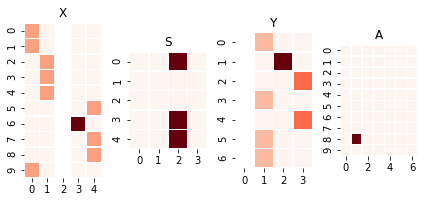

In [10]:
fig, ax = plt.subplots(1,4)
plot_matrix(sampler.X_prime, name="X", ax=ax[0])
plot_matrix(sampler.Y_prime, name="Y", ax=ax[2])
plot_matrix(sampler.S_prime, name="S", ax=ax[1])
plot_matrix(sampled_A, name="A", ax=ax[3])
fig.tight_layout()

In [11]:
from scipy.sparse import csc_matrix


def howManyEdges(X, S, Y=None):
    if Y is None:
        Y = X
    Cx = np.sum(X, axis=0)
    Cy = np.sum(Y, axis=0)
    
    em = Cx @ np.sum(S * Cy, axis=1)
    avDeg = em / X.shape[0]
    
    return em, avDeg


def fastRG(X, S, Y=None, avgDeg=None, simple=None, PoissonEdges=True, 
           directed=False, selfLoops=False, returnEdgeList=False, 
           returnParameters=False):
    """
    Rohe, K., Tao, J., Han, X., & Binkiewicz, N. (2017). A note on quickly 
    sampling a sparse matrix with low rank expectation. arXiv preprint 
    arXiv:1703.02998.
    
    Implementation of fastRG in R
    https://github.com/karlrohe/fastRG
    """
    
    if Y is not None and Y.size > 0:
        directed = True
        selfLoops = True
        simple = False
        returnY = True
    
    else:
        Y = X
        returnY = False
    
    if np.any(X < 0) or np.any(S < 0) or np.any(Y < 0):
        return None
    
    if simple is not None and simple:
        selfLoops = False
        directed = False
        PoissonEdges = False
    
    n, K1 = X.shape
    d, K2 = Y.shape
  
  
    if avgDeg is not None:
        _, eDbar = howManyEdges(X, S, Y)
        S *= avgDeg / eDbar
     
  
    if not directed:
        S = (S + S.T) * 0.25
        
    Cx = np.sum(X, axis=0)
    Cy = np.sum(Y, axis=0)
    Xt = (X * (1 / Cx)).T
    Yt = (Y * (1 / Cy)).T  
  
    St = Cx[:, None] * S * Cy
    m = np.random.poisson(np.sum(St))  

    if m == 0:
        A = csc_matrix((n, d))
        return (A, X, S, Y if returnY else None) if returnParameters else A
        
    tabUV = np.random.multinomial(m, pvals=St.ravel() * (1 / np.sum(St))).reshape((K1, K2))
    
    elist = np.empty((2, m))
    eitmp = np.empty(m)
    
    blockDegreesU = np.sum(tabUV, axis=1)
    tickerU = np.insert(np.cumsum(blockDegreesU), 0, 0) 
    
    for u in range(K1):
        if blockDegreesU[u] > 0:
            elist[0, tickerU[u]:tickerU[u+1]] = np.random.choice(np.arange(n), size=blockDegreesU[u], 
                                                                 replace=True, p=Xt[u])
      
    blockDegreesV = np.sum(tabUV, axis=0)
    tickerV = np.insert(np.cumsum(blockDegreesV), 0, 0) 
    
    for v in range(K2):
        if blockDegreesV[v] > 0:
            eitmp[tickerV[v]:tickerV[v+1]] = np.random.choice(np.arange(d), size=blockDegreesV[v], 
                                                              replace=True, p=Yt[v])

    ticker = 0
    for u in range(K1):
        for v in range(K2):   
            if tabUV[u,v] > 0:            
                elist[1, ticker:ticker + tabUV[u,v]] = eitmp[tickerV[v]:tickerV[v] + tabUV[u,v]]
                ticker += tabUV[u, v]
                
    elist = elist.T

    if not selfLoops:
        elist = elist[np.where(elist[:, 0] != elist[:, 1])]
        
    if not directed:
        if n != d:
            raise Exception("{0} != {1}: Undirected network requests n == d".format(n, d))
        
        elist = np.concatenate((elist, elist[:, ::-1]))

    if not PoissonEdges:       
        e = np.ascontiguousarray(elist)
        e_unique = np.unique(e.view([('', np.int), ('', np.int)]))
        elist = e_unique.view(np.int).reshape((e_unique.shape[0], 2))
          
    if returnEdgeList:
        return elist
    
    else:
        A = csc_matrix((np.ones(elist.shape[0], dtype=np.int), 
                        (elist[:, 0], elist[:, 1])), 
                       shape=(n, d), dtype=np.int)      

        return (A, X, S, Y if returnY else None) if returnParameters else A


In [12]:
np.any(X.toarray() < 0)

False

In [13]:
np.any(X < 0).sum()

0

In [14]:
sampled_A1 = fastRG(X.toarray(), S.toarray(), Y.toarray())

/Users/smishra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in true_divide
/Users/smishra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in multiply
/Users/smishra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide
/Users/smishra/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in multiply


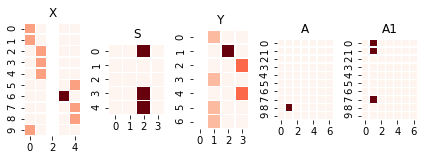

In [15]:
fig, ax = plt.subplots(1,5)
plot_matrix(sampler.X_prime, name="X", ax=ax[0])
plot_matrix(sampler.Y_prime, name="Y", ax=ax[2])
plot_matrix(sampler.S_prime, name="S", ax=ax[1])
plot_matrix(sampled_A, name="A", ax=ax[3])
plot_matrix(sampled_A1, name="A1", ax=ax[4])
fig.tight_layout()

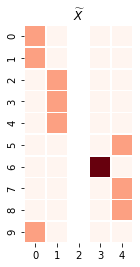

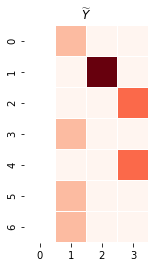

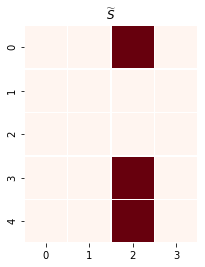

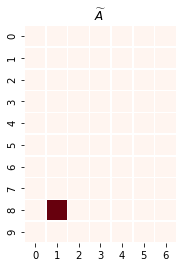

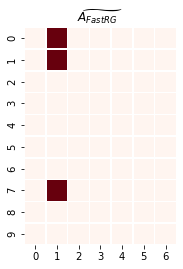

In [16]:
# fig, ax = plt.subplots(1,5)
ax = [None, None, None, None, None]
plot_matrix(sampler.X_prime, name="$\widetilde{X}$", ax=ax[0])
plot_matrix(sampler.Y_prime, name="$\widetilde{Y}$", ax=ax[2])
plot_matrix(sampler.S_prime, name="$\widetilde{S}$", ax=ax[1])
plot_matrix(sampled_A, name="$\widetilde{A}$", ax=ax[3])
plot_matrix(sampled_A1, name="$\widetilde{A_{FastRG}}$", ax=ax[4])
# fig.tight_layout()

In [17]:
sampled_A.todense()

matrix([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]], dtype=int64)

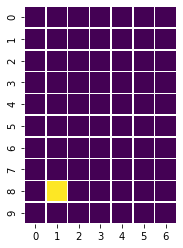

In [18]:
sns.heatmap(
    sampled_A.todense(), cmap="viridis", 
#         vmin=0, vmax=1,
    linewidths=.5,
    square=True, cbar=False, 
#     ax=ax
)
#     ax.set_title(name)|